<a href="https://colab.research.google.com/github/KacperGrodecki/nieruchomosci-mazowieckie/blob/main/mazowieckie_colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
from sklearn.metrics import confusion_matrix
from sklearn import svm
import pandas as pd
import numpy as np
np.random.seed(7)
from google.colab import drive
import seaborn as sns
drive.mount('/content/drive')
import matplotlib.pyplot as plt
import pandas as pd
#from otoDomScraper import daneDomu
#from random import randrange
import numpy as np
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt
import seaborn as sns
import re
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
import statistics
from sklearn.cluster import AffinityPropagation
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.decomposition import FastICA
from sklearn import preprocessing
from IPython.display import Javascript
from tensorflow_decision_forests.tensorflow import core as tf_core

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
def toNum2(txt):
    if type(txt) is int:
        return txt
    elif (type(txt) is str):
        digs = re.findall(r'\d+', txt)
        if len(digs) == 1:
            return int(digs[0])
        elif len(digs) == 2:
            return 1000 * int(digs[0]) + int(digs[1])
        elif len(digs) == 3:
            return 1000000 * int(digs[0]) + 1000 * int(digs[1]) + int(digs[0])

    #   return int(digs)


def toNum1(txt):
    if type(txt) is str:
        digs = re.findall(r'\d+', txt)
        if len(digs) == 1:
            return int(digs[0])
        elif len(digs) == 2 and (txt[1] != ' '):
            return int(digs[0]) + 0.01 * int(digs[1])
        elif len(digs) == 3:
            return 1000 * int(digs[0]) + int(digs[1]) + 0.001 * int(digs[2])
        elif (type(txt) is str) and (txt[1] == ' '):
            digs = re.findall(r'\d+', txt)
            return 1000 * int(digs[0]) + int(digs[1])
    else:
        return txt


def toNum3(txt):
    if type(txt) == int:
        return txt
    return int(re.findall(r'\d+', txt)[0])

def pietra(txt):
    if type(txt) is str:
        if '0' in txt:
            return 0
        if '1' in txt:
            return 1
        elif '2' in txt:
            return 2
        elif '3' in txt:
            return 3
        elif 'parterowy' in txt:
            return 0
    else:
        return txt

def cities(x):
    dist=x.split()[4]
    #city=x.split()[5]
    if dist=='warszawski':
        return x.split()[6]
    elif dist in ['Warszawa','Radom','Płock','Siedlce']:
        return dist
    else:
        try:
            return x.split()[5]
        except:
            return 'unknown'

def region(x):
    if x.split()[4]=='Warszawa':
        try:
            return x.split()[5]
        except:
            return ''
    else:
        return ''

In [5]:
def makeDataFrame(file):
    dfMazowieckie=pd.read_csv(file,index_col=0)
    concat=dfMazowieckie
    concat['powierzchnia_corr'] = concat['powierzchnia'].apply(lambda x: toNum1(x))
    concat['powierzchniaDzialki_corr'] = concat['powierzchniaDzialki'].apply(lambda x: toNum2(x))
    concat['cena_corr'] = concat['cena'].apply(lambda x: toNum2(x))
    concat['rokBudowy_corr'] = concat['rokBudowy'].apply(lambda x: toNum3(x))
    concat['cena/m'] = concat['cena_corr'] / concat['powierzchnia_corr']
    concat['lPieter_crr'] = concat['lPieter'].apply(lambda x: pietra(x))
    concat = concat[concat['powierzchnia_corr'] > 0]
    concat = concat[concat['cena_corr'] > 0]
    concat['lPokoi'] = concat['lPokoi'].apply(lambda x: toNum3(x))
    concat['districts']=concat['dzielnica'].apply(lambda x: x.split()[4])
    cities_corr=concat['dzielnica'].apply(lambda x: cities(x))
    concat['cities_corr']=cities_corr
    region_corr=concat['dzielnica'].apply(lambda x: region(x))
    concat['region_corr']=region_corr
    concat_dropped = concat.drop(['dzielnica', 'powierzchnia', 'powierzchniaDzialki', 'lPieter', 'cena', 'cena_corr',], axis=1)
    concat_dropped['rokBudowy'] = concat_dropped['rokBudowy'].replace(to_replace=0, value=1990)
    concat_dropped['rokBudowy'] = concat_dropped['rokBudowy'].astype('int')
    concat_dropped = concat_dropped.fillna(0)
    concat_dropped = concat_dropped[concat_dropped['cena/m'] < 20000]
    concat_dropped['cena/m'].hist(bins=200)
    concat_dropped_dumm = pd.get_dummies(concat_dropped, columns=['rodzajZabudowy', 'materialBudynku', 'stanWykonczenia', 'okna', 'rynek',
                                             'cities_corr','districts','region_corr'])
    return concat_dropped_dumm,concat_dropped

In [6]:
filename='/content/drive/My Drive/domy mazowieckie/dfMazowieckie.csv'

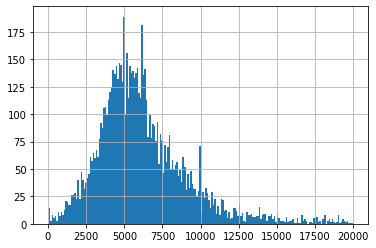

In [7]:
concat_dropped_dumm,concat_dropped=makeDataFrame(filename)

In [8]:
concat_dropped_dumm.head()

,lPokoi,rokBudowy,powierzchnia_corr,powierzchniaDzialki_corr,rokBudowy_corr,cena/m,lPieter_crr,rodzajZabudowy_0,rodzajZabudowy_bliźniak,rodzajZabudowy_dworek/pałac,rodzajZabudowy_gospodarstwo,rodzajZabudowy_kamienica,rodzajZabudowy_szeregowiec,rodzajZabudowy_wolnostojący,materialBudynku_0,materialBudynku_beton,materialBudynku_beton komórkowy,materialBudynku_cegła,materialBudynku_drewno,materialBudynku_inne,materialBudynku_keramzyt,materialBudynku_pustak,materialBudynku_silikat,stanWykonczenia_0,stanWykonczenia_do remontu,stanWykonczenia_do wykończenia,stanWykonczenia_do zamieszkania,stanWykonczenia_stan surowy otwarty,stanWykonczenia_stan surowy zamknięty,okna_0,okna_aluminiowe,okna_brak,okna_drewniane,okna_plastikowe,rynek_pierwotny,rynek_wtórny,cities_corr_Adamowice,cities_corr_Adamowizna,cities_corr_Adamowo,cities_corr_Adampol,...,districts_przasnyski,districts_przysuski,districts_pułtuski,districts_płocki,districts_płoński,districts_radomski,districts_siedlecki,districts_sierpecki,districts_sochaczewski,districts_sokołowski,districts_szydłowiecki,districts_warszawski,districts_wołomiński,districts_wyszkowski,districts_węgrowski,districts_zwoleński,districts_łosicki,districts_żuromiński,districts_żyrardowski,region_corr_,region_corr_Aleksandrów,region_corr_Bemowo,region_corr_Białołęka,region_corr_Bielany,region_corr_Mokotów,region_corr_Ochota,region_corr_Praga-Południe,region_corr_Praga-Północ,region_corr_Rembertów,region_corr_Targówek,region_corr_Ursus,region_corr_Ursynów,region_corr_Wawer,region_corr_Wesoła,region_corr_Wilanów,region_corr_Wola,region_corr_Włochy,region_corr_ul.,region_corr_Śródmieście,region_corr_Żoliborz
0,6,2019,320.00,1000,2019,6062.503125,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
1,5,2021,154.00,750,2021,5186.363636,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,3,1950,80.00,2356,1950,5612.500000,1,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,4,2022,152.91,220,2022,4250.866523,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,4,2020,106.00,960,2020,2924.528302,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [37]:
from sklearn.decomposition import FastICA
transformer = FastICA(n_components=20,random_state=0)
x_tr = transformer.fit_transform(concat_dropped_dumm.drop(['cena/m'],axis=1).values)

In [45]:
pd_x_tr=pd.DataFrame(x_tr)

In [87]:
pd_x_tr['cena/m']=concat_dropped_dumm['cena/m']
pd_x_tr= pd_x_tr.fillna(0)

In [94]:
pd_x_tr.columns=['a0','a1','a2','a3','a4','a5','a6','a7','a8','a9','a10','a11','a12','a13','a14','a15','a16','a17','a18','a19','cena/m',]

In [68]:
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(pd_x_tr.values)
df = pd.DataFrame(x_scaled,columns=['a0','a1','a2','a3','a4','a5','a6','a7','a8','a9','a10','a11','a12','a13','a14','a15','a16','a17','a18','a19','cena/m',])
df  = df.fillna(0)

In [69]:
df.head()

,a0,a1,a2,a3,a4,a5,a6,a7,a8,a9,a10,a11,a12,a13,a14,a15,a16,a17,a18,a19,cena/m
0,0.000142,0.538168,0.960679,0.124256,0.963230,0.201166,0.577541,0.838554,0.874352,0.864407,0.669552,0.855231,0.578469,0.777769,0.994382,0.136624,0.654157,0.878563,0.818298,0.584550,0.302205
1,0.000221,0.067467,0.961486,0.755807,0.810324,0.500746,0.585708,0.771617,0.506184,0.712844,0.572349,0.576593,0.548809,0.841463,0.994276,0.708190,0.764086,0.201298,0.806505,0.556634,0.258250
2,0.000174,0.580600,0.969335,0.238737,0.854292,0.914767,0.409551,0.723284,0.933732,0.871902,0.734715,0.280551,0.655080,0.739266,0.994164,0.146112,0.502043,0.866283,0.711063,0.611030,0.279629
3,0.000202,0.808070,0.956856,0.169802,0.830681,0.534666,0.472344,0.143991,0.495246,0.676274,0.533429,0.592232,0.609226,0.838978,0.994351,0.795495,0.655343,0.153414,0.850874,0.555981,0.211317
4,0.000225,0.491747,0.964443,0.156760,0.561536,0.521172,0.588678,0.760030,0.276864,0.121652,0.724362,0.393098,0.676338,0.801216,0.994720,0.120101,0.685216,0.540374,0.785667,0.565439,0.144776


In [95]:
pd_x_tr.head()

,a0,a1,a2,a3,a4,a5,a6,a7,a8,a9,a10,a11,a12,a13,a14,a15,a16,a17,a18,a19,cena/m
0,-0.000177,-0.001001,0.000577,-0.006818,0.009628,-0.012993,0.002223,0.007161,0.022403,0.005653,0.002857,0.018774,0.004134,0.001549,0.000612,-0.010485,0.011355,0.014473,0.010364,0.004863,6062.503125
1,-0.000097,-0.024244,0.000827,0.026696,0.003123,-0.001496,0.002967,0.003909,-0.001205,-0.001537,-0.003566,0.005834,0.001650,0.005562,0.000537,0.010139,0.018199,-0.010465,0.009876,0.003027,5186.363636
2,-0.000144,0.001095,0.003265,-0.000743,0.004993,0.014393,-0.013073,0.001560,0.026210,0.006008,0.007162,-0.007914,0.010551,-0.000877,0.000458,-0.010143,0.001884,0.014021,0.005931,0.006605,5612.500000
3,-0.000116,0.012327,-0.000610,-0.004401,0.003989,-0.000194,-0.007356,-0.026583,-0.001906,-0.003272,-0.006137,0.006560,0.006710,0.005405,0.000590,0.013290,0.011429,-0.012228,0.011711,0.002984,4250.866523
4,-0.000094,-0.003293,0.001746,-0.005093,-0.007463,-0.000712,0.003237,0.003346,-0.015909,-0.029581,0.006478,-0.002687,0.012332,0.003026,0.000852,-0.011081,0.013289,0.002020,0.009015,0.003606,2924.528302


In [11]:
!pip install tensorflow_decision_forests

     |████████████████████████████████| 6.3 MB 3.0 MB/s 


In [12]:
!pip install wurlitzer

In [13]:
import tensorflow_decision_forests as tfdf

import os
import numpy as np
import pandas as pd
import tensorflow as tf
import math

try:
  from wurlitzer import sys_pipes
except:
  from colabtools.googlelog import CaptureLog as sys_pipes

from IPython.core.magic import register_line_magic
from IPython.display import Javascript

In [14]:
# Check the version of TensorFlow Decision Forests
print("Found TensorFlow Decision Forests v" + tfdf.__version__)


Found TensorFlow Decision Forests v0.1.8


In [ ]:
def split_dataset(dataset, test_ratio=0.30):
  """Splits a panda dataframe in two."""
  test_indices = np.random.rand(len(dataset)) < test_ratio
  return dataset[~test_indices], dataset[test_indices]

In [108]:
train_ds_pd, test_ds_pd = split_dataset(df)
print("{} examples in training, {} examples for testing.".format(
    len(train_ds_pd), len(test_ds_pd)))


5439 examples in training, 2384 examples for testing.


alternatywna macierz bez min max scaller

In [98]:
train_ds_pd, test_ds_pd = split_dataset(pd_x_tr)
print("{} examples in training, {} examples for testing.".format(
    len(train_ds_pd), len(test_ds_pd)))


5443 examples in training, 2380 examples for testing.


In [109]:
#train_ds = tfdf.keras.pd_dataframe_to_tf_dataset(train_ds_pd, label=label)
Task = tf_core.Task
train_ds=tfdf.keras.pd_dataframe_to_tf_dataset(
    train_ds_pd,
    label='cena/m',
    task=Task.REGRESSION
)

test_ds = tfdf.keras.pd_dataframe_to_tf_dataset(
    test_ds_pd,
    label='cena/m',
    task=Task.REGRESSION
)

In [110]:
# A classical but slighly more complex model.
model_tune = tfdf.keras.GradientBoostedTreesModel(
    task=Task.REGRESSION,num_trees=2000, growing_strategy="BEST_FIRST_GLOBAL", max_depth=2000)
model_tune.compile(
    metrics=['mse',"mae",'acc'])
model_tune.fit(train_ds)

85/85 [==============================] - 0s 2ms/step


In [120]:
evaluation = model_tune.evaluate(train_ds, return_dict=True)
print()

for name, value in evaluation.items():
  print('alsolute ',f"{name}: {value:.4f}")
  print('relative ',f"{name}: {100*value/df['cena/m'].mean():.4f}")

85/85 [==============================] - 0s 3ms/step - loss: 0.0000e+00 - mse: 0.0251 - mae: 0.1162 - acc: 0.0601

alsolute  loss: 0.0000
relative  loss: 0.0000
alsolute  mse: 0.0251
relative  mse: 8.6277
alsolute  mae: 0.1162
relative  mae: 39.8738
alsolute  acc: 0.0601
relative  acc: 20.6378


In [121]:
evaluation = model_tune.evaluate(test_ds, return_dict=True)
print()

for name, value in evaluation.items():
  print('alsolute ',f"{name}: {value:.4f}")
  print('relative ',f"{name}: {100*value/df['cena/m'].mean():.4f}")

38/38 [==============================] - 0s 3ms/step - loss: 0.0000e+00 - mse: 0.0277 - mae: 0.1217 - acc: 0.0642

alsolute  loss: 0.0000
relative  loss: 0.0000
alsolute  mse: 0.0277
relative  mse: 9.5110
alsolute  mae: 0.1217
relative  mae: 41.7866
alsolute  acc: 0.0642
relative  acc: 22.0302
